In [1]:
# Install required packages
# !pip install catboost xgboost shap joblib

# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import shap
import time
import joblib
import warnings
import pickle
from catboost import CatBoostRegressor
from urllib.request import urlopen
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Define constants
config = {
    'file_path': "https://raw.githubusercontent.com/Alex-Malainic/Solar-Energy/main/SunPower_Full.csv",
    'target_variable': 'Active_Power',
    'predictors': ['temperature_2m', 'relativehumidity_2m', 'direct_radiation', 'diffuse_radiation', 'windspeed_10m', 'cloudcover', 'season'],
    'categorical_variables': ['season'],
    'time_intervals': ['first_interval','second_interval','third_interval','fourth_interval','fifth_interval','sixth_interval'],
    'weather_types': ['TypeA', 'TypeB', 'TypeC'],
    'standardize_predictor_list': ['temperature_2m', 'relativehumidity_2m', 'direct_radiation', 'diffuse_radiation', 'windspeed_10m', 'cloudcover']
}

# Data processing functions
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df.rename(columns={'timestamp':'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df[config['target_variable']] = df[config['target_variable']].clip(lower=0)
    return df

def add_season(df):
    def season(month):
        if month in [12, 1, 2]: return 'winter'
        elif month in [3, 4, 5]: return 'spring'
        elif month in [6, 7, 8]: return 'summer'
        else: return 'fall'
    df['season'] = df['date'].dt.month.apply(season)
    return df

def choose_interval(df):
    df = df.sort_values('date').set_index('date')
    df = df.between_time('07:00', '18:00')
    return df

def split_data(df):
    ord_enc = OrdinalEncoder()
    df['season'] = ord_enc.fit_transform(np.array(df['season']).reshape(-1,1))
    cutoff_date = df.index.min() + pd.DateOffset(years=7)
    train = df.loc[:cutoff_date]
    test = df.loc[cutoff_date + pd.DateOffset(hours=1):]
    return train, test

def detect_time_interval(df):
    intervals = {'first_interval': (7, 9), 'second_interval': (9, 11), 'third_interval': (11, 13),
                'fourth_interval': (13, 15), 'fifth_interval': (15, 17), 'sixth_interval': (17, 18)}
    df['time_interval'] = pd.cut(df.index.hour, bins=[i[0] for i in intervals.values()] + [24],
                                labels=intervals.keys(), include_lowest=True, right=False)
    return df

def create_weather_type(train):
    new_train = pd.DataFrame()
    for interval in config['time_intervals']:
        train_df = train[train['time_interval'] == interval].copy()
        weather_type = []
        avg_kwh = np.mean(train_df[config['target_variable']])
        max_kwh = max(train_df[config['target_variable']])
        min_kwh = min(train_df[config['target_variable']])
        for y in train_df[config['target_variable']]:
            if y >= avg_kwh: weather_type.append("TypeA")
            elif y > avg_kwh - (avg_kwh - min_kwh) / 2 and y < avg_kwh: weather_type.append("TypeB")
            elif y >= 0 and y <= avg_kwh - (avg_kwh - min_kwh)/2: weather_type.append("TypeC")
            else: raise ValueError(f"Error in weather type classification for {interval}")
        train_df['weather_type'] = weather_type
        new_train = pd.concat([new_train, train_df])
    return new_train.sort_index()

def train_rf_classifier(X_train, y_train):
    param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def predict_weather_type(grid_search, X_test):
    y_pred = grid_search.best_estimator_.predict(X_test)
    X_test['weather_type'] = y_pred
    return X_test

def classify_weather_type(new_train, test):
    new_test = pd.DataFrame()
    for interval in config['time_intervals']:
        interval_train = new_train[new_train['time_interval'] == interval].copy()
        interval_test = test[test['time_interval'] == interval].copy()
        try:
            grid = joblib.load(urlopen(f'https://raw.githubusercontent.com/Alex-Malainic/Solar-Energy/main/ClassifiedWeatherTypes/RF_Weather_{interval}_.pkl'))
            classified_weather_type = predict_weather_type(grid, interval_test[config['predictors']].copy())
        except:
            grid = train_rf_classifier(interval_train[config['predictors']], interval_train['weather_type'])
            classified_weather_type = predict_weather_type(grid, interval_test[config['predictors']].copy())
        classified_weather_type['time_interval'] = interval
        print(f"Weather type Predictions done for {interval}")
        new_test = pd.concat([new_test, classified_weather_type])
    return new_test.sort_index()

def standardize_data(new_train, new_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(new_train[config['standardize_predictor_list']])
    X_test = scaler.transform(new_test[config['standardize_predictor_list']])
    new_stand_train = pd.DataFrame(X_train, index=new_train.index, columns=config['standardize_predictor_list'])
    new_stand_test = pd.DataFrame(X_test, index=new_test.index, columns=config['standardize_predictor_list'])
    new_stand_train = pd.concat([new_stand_train, new_train[['season', config['target_variable'], 'weather_type', 'time_interval']]], axis=1)
    new_stand_test = pd.concat([new_stand_test, new_test[['season', 'weather_type', 'time_interval']]], axis=1)
    return new_stand_train, new_stand_test

# Model definitions
def train_XGB_regressor(X_train, y_train):
    param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'colsample_bytree': [0.3, 0.7]}
    grid_search = GridSearchCV(XGBRegressor(verbosity=0), param_grid, scoring='neg_root_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train, verbose=0)
    return grid_search

def train_RF_regressor(X_train, y_train):
    param_grid = {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring='neg_root_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def train_MLP_regressor(X_train, y_train):
    param_grid = {'alpha': 10.0 ** -np.arange(1, 4), 'learning_rate_init': [0.01, 0.001]}
    grid_search = GridSearchCV(MLPRegressor(hidden_layer_sizes=(15,15), solver='adam', max_iter=1000), param_grid, scoring='neg_root_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def train_CB_regressor(X_train, y_train):
    param_grid = {'iterations': [100, 200], 'learning_rate': [0.05], 'depth': [6, 8]}
    grid_search = GridSearchCV(CatBoostRegressor(verbose=0), param_grid, scoring='neg_root_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train, verbose=False)
    return grid_search

# Training and prediction functions
def train_predict_model(model_func, model_name, new_stand_train, new_stand_test):
    forecast_test = pd.DataFrame()
    for interval, weather_type in product(config['time_intervals'], config['weather_types']):
        X_train = new_stand_train[(new_stand_train['time_interval'] == interval) & (new_stand_train['weather_type'] == weather_type)][config['predictors']]
        y_train = new_stand_train[(new_stand_train['time_interval'] == interval) & (new_stand_train['weather_type'] == weather_type)][config['target_variable']]
        X_test = new_stand_test[(new_stand_test['time_interval'] == interval) & (new_stand_test['weather_type'] == weather_type)][config['predictors']]
        if len(X_train) < 10 or len(X_test) < 1:
            continue
        try:
            md = joblib.load(urlopen(f'https://raw.githubusercontent.com/Alex-Malainic/Solar-Energy/main/Fitted_Models/{model_name}_fitted_{interval}_{weather_type}.pkl'))
            predictions = md.predict(X_test)
        except:
            md = model_func(X_train, y_train)
            predictions = md.predict(X_test)
        print(f"{model_name} Predictions done for {interval, weather_type}")
        TestingData = pd.DataFrame(data=X_test.copy(), columns=X_test.columns)
        TestingData['PredictedTotalPower'] = predictions
        forecast_test = pd.concat([forecast_test, TestingData])
    return forecast_test.sort_index()

# Evaluation function
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

def evaluate_model(model_name, forecast_test, test, new_test):
    y_test = test.loc[new_test.index, config['target_variable']]
    forecast_test['ActualTotalPower'] = y_test
    forecast_test['PredictedTotalPower'] = forecast_test['PredictedTotalPower'].clip(lower=0)
    mae = metrics.mean_absolute_error(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    rmse = np.sqrt(metrics.mean_squared_error(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower']))
    r2 = metrics.r2_score(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    smape_ = smape(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    print(f"\n{model_name} Model Evaluation Results:")
    print("MAE:", round(mae, 3))
    print("RMSE:", round(rmse, 3))
    print(f"R-Squared: {round(r2, 3) * 100}%")
    print(f"Scaled Mean Absolute Percentage Error: {round(smape_, 3)}%")
    return mae, rmse, r2, smape_

# Main execution
def main():
    print("Loading and processing data...")
    df = load_data(config['file_path'])
    df = add_season(df)
    df = choose_interval(df)
    train, test = split_data(df)
    train = detect_time_interval(train)
    test = detect_time_interval(test)
    new_train_data = create_weather_type(train)
    new_test_data = classify_weather_type(new_train_data, test)
    new_stand_train, new_stand_test = standardize_data(new_train_data, new_test_data)

    # Train and evaluate all models
    models = [
        (train_MLP_regressor, "MLP", "MLP"),
        (train_CB_regressor, "CatBoost", "CB"),
        (train_XGB_regressor, "XGBoost", "XGB"),
        (train_RF_regressor, "RandomForest", "RF")
    ]

    results = {}
    for model_func, model_name, model_prefix in models:
        print(f"\nTraining and predicting with {model_name}...")
        forecast_data = train_predict_model(model_func, model_prefix, new_stand_train, new_stand_test)
        results[model_name] = evaluate_model(model_name, forecast_data, test, new_test_data)

    # Summary of results
    print("\nSummary of Model Performance:")
    print("Model | MAE | RMSE | R² (%) | SMAPE (%)")
    print("-" * 50)
    for model_name, (mae, rmse, r2, smape_) in results.items():
        print(f"{model_name:12} | {round(mae,3):5} | {round(rmse,3):5} | {round(r2*100,3):6} | {round(smape_,3):6}")

if __name__ == "__main__":
    main()

Loading and processing data...


<ipython-input-1-5bc94ede1958>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_interval'] = pd.cut(df.index.hour, bins=[i[0] for i in intervals.values()] + [24],
<ipython-input-1-5bc94ede1958>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_interval'] = pd.cut(df.index.hour, bins=[i[0] for i in intervals.values()] + [24],


Weather type Predictions done for first_interval
Weather type Predictions done for second_interval
Weather type Predictions done for third_interval
Weather type Predictions done for fourth_interval
Weather type Predictions done for fifth_interval
Weather type Predictions done for sixth_interval

Training and predicting with MLP...
MLP Predictions done for ('first_interval', 'TypeA')
MLP Predictions done for ('first_interval', 'TypeB')
MLP Predictions done for ('first_interval', 'TypeC')
MLP Predictions done for ('second_interval', 'TypeA')
MLP Predictions done for ('second_interval', 'TypeB')
MLP Predictions done for ('second_interval', 'TypeC')
MLP Predictions done for ('third_interval', 'TypeA')
MLP Predictions done for ('third_interval', 'TypeB')
MLP Predictions done for ('third_interval', 'TypeC')
MLP Predictions done for ('fourth_interval', 'TypeA')
MLP Predictions done for ('fourth_interval', 'TypeB')
MLP Predictions done for ('fourth_interval', 'TypeC')
MLP Predictions done for 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:43:16] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


XGB Predictions done for ('first_interval', 'TypeA')
XGB Predictions done for ('first_interval', 'TypeB')
XGB Predictions done for ('first_interval', 'TypeC')
XGB Predictions done for ('second_interval', 'TypeA')
XGB Predictions done for ('second_interval', 'TypeB')
XGB Predictions done for ('second_interval', 'TypeC')
XGB Predictions done for ('third_interval', 'TypeA')
XGB Predictions done for ('third_interval', 'TypeB')
XGB Predictions done for ('third_interval', 'TypeC')
XGB Predictions done for ('fourth_interval', 'TypeA')
XGB Predictions done for ('fourth_interval', 'TypeB')
XGB Predictions done for ('fourth_interval', 'TypeC')
XGB Predictions done for ('fifth_interval', 'TypeA')
XGB Predictions done for ('fifth_interval', 'TypeB')
XGB Predictions done for ('fifth_interval', 'TypeC')
XGB Predictions done for ('sixth_interval', 'TypeA')
XGB Predictions done for ('sixth_interval', 'TypeB')
XGB Predictions done for ('sixth_interval', 'TypeC')

XGBoost Model Evaluation Results:
MAE: 

In [3]:
!pip install --no-cache-dir --force-reinstall numpy==1.26.4 pandas==2.2.2 scikit-learn==1.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 211.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 254.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 198.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 289.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 299.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 276.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 252.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 273.2 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.1
    Uninstalling pytz-2025.1:
      Successfully uninstalled pytz-2025.1
  Attempting uninstall: tzdata
    Found exist

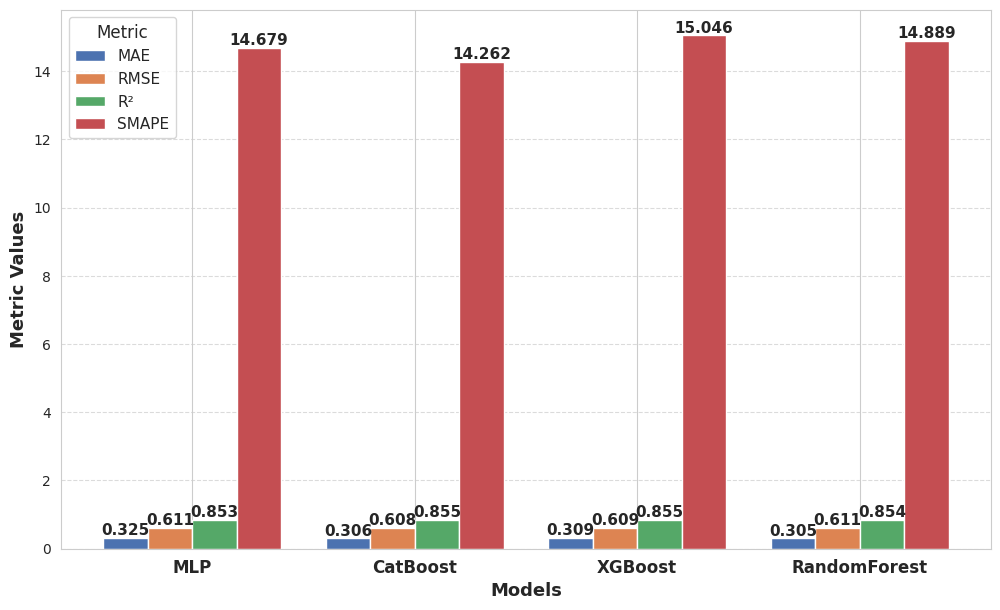

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Model names
models = ['MLP', 'CatBoost', 'XGBoost', 'RandomForest']

# Performance metrics (with corrected R²)
mae = [0.325, 0.306, 0.309, 0.305]
rmse = [0.611, 0.608, 0.609, 0.611]
r2 = [0.853, 0.855, 0.855, 0.854]  # Converted from percentage
smape = [14.679, 14.262, 15.046, 14.889]

# Setting up bar width and positions
bar_width = 0.2
x = np.arange(len(models))

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bars for each metric
bars1 = ax.bar(x - 1.5 * bar_width, mae, bar_width, label='MAE', color='#4c72b0')
bars2 = ax.bar(x - 0.5 * bar_width, rmse, bar_width, label='RMSE', color='#dd8452')
bars3 = ax.bar(x + 0.5 * bar_width, r2, bar_width, label='R²', color='#55a868')
bars4 = ax.bar(x + 1.5 * bar_width, smape, bar_width, label='SMAPE', color='#c44e52')

# Adding text labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Labels and title
ax.set_xlabel("Models", fontsize=13, fontweight="bold")
ax.set_ylabel("Metric Values", fontsize=13, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12, fontweight="bold")
ax.legend(fontsize=11, title="Metric", title_fontsize=12, loc="upper left", frameon=True)

# Improve aesthetics with grid and color balance
ax.grid(axis='y', linestyle="--", alpha=0.7)

# Display the plot
plt.show()
